In [56]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
import numpy as np


%load_ext rpy2.ipython

from pylab import rcParams
size = 20
params = {'legend.fontsize': size,
          'figure.figsize': (15, 5),
         'axes.labelsize': size, 
         'axes.titlesize':size, 
         'xtick.labelsize':size, 
         'ytick.labelsize':size, 
          'axes.titlesize':1.5*size, 
         'figure.figsize': (12, 12)}
rcParams.update(params)
theme_update(figure_size=(9, 9), title=element_text(size=size), text=element_text(size=.6*size)) # for plotnine

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R
library(ggplot2) 
theme_set(theme_grey(base_size = 24)) 

Outline

* Plots 
    * Bar 
    * Histogram
    * Scatter 
    * Box and whisker
    * Line 
        * Time series
* Extensions
    * Faceting on categorical
    * Stacked bar/histogram
    * Line over scatter
    * Multi color/symbol scatter
    * Multiple line plots
* Modifications
    * Log scaled axes
    * Time labeled axes
    * Histogram bin-width
    * Aspect ratio
    * Axis boundaries


## Load Data

Data is from [ggplot2](http://ggplot2.tidyverse.org/reference/mpg.html).

Many ggplot examples taken from [R for data science](http://r4ds.had.co.nz/visualize.html) by Garrett Grolemund and Hadley Wickham.

In [3]:
%%R
summary(mpg)

 manufacturer          model               displ            year     
 Length:234         Length:234         Min.   :1.600   Min.   :1999  
 Class :character   Class :character   1st Qu.:2.400   1st Qu.:1999  
 Mode  :character   Mode  :character   Median :3.300   Median :2004  
                                       Mean   :3.472   Mean   :2004  
                                       3rd Qu.:4.600   3rd Qu.:2008  
                                       Max.   :7.000   Max.   :2008  
      cyl           trans               drv                 cty       
 Min.   :4.000   Length:234         Length:234         Min.   : 9.00  
 1st Qu.:4.000   Class :character   Class :character   1st Qu.:14.00  
 Median :6.000   Mode  :character   Mode  :character   Median :17.00  
 Mean   :5.889                                         Mean   :16.86  
 3rd Qu.:8.000                                         3rd Qu.:19.00  
 Max.   :8.000                                         Max.   :35.00  
      hwy    

In [57]:
mpg = pd.read_csv('https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/mpg.csv')
diamonds = pd.read_csv('https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv')

ts = (pd
      .Series(np.random.randn(1000), 
              index=pd.date_range('1/1/2000', periods=1000))
      .cumsum()
      .to_frame()
      .reset_index()
     )
ts.columns = ['date', 'value']

In [58]:
from IPython.display import display, HTML
display(HTML(ts.head(5).to_html(index=False)))

date,value
2000-01-01,0.480168
2000-01-02,1.961034
2000-01-03,1.735043
2000-01-04,1.611648
2000-01-05,1.966705


In [59]:
from IPython.display import display, HTML
display(HTML(mpg.head(5).to_html(index=False)))

manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact


In [54]:
from IPython.display import display, HTML
display(HTML(diamonds.head(5).to_html(index=False)))

carat,cut,color,clarity,depth,table,price,x,y,z
0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Plots

### Basic Plots

#### Bar Charts of Counts

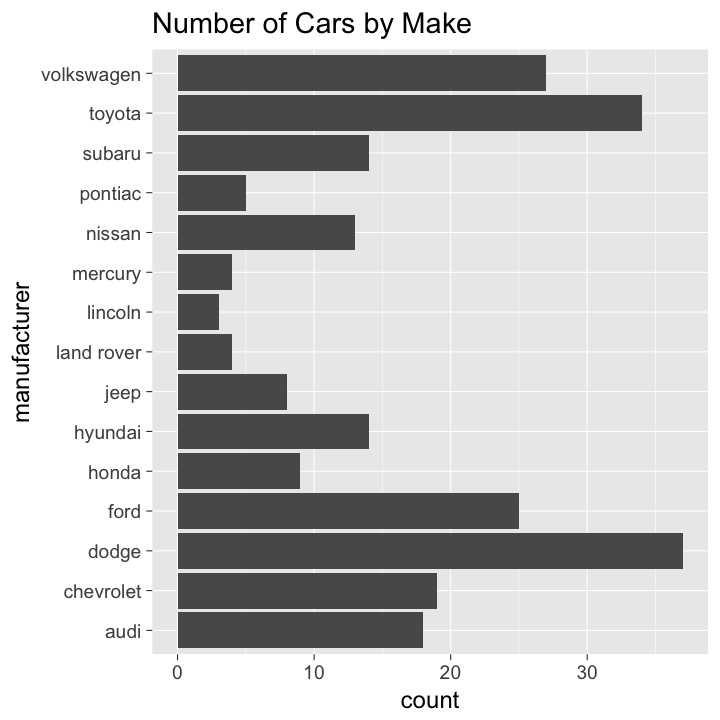

In [5]:
%%R -w 10 -h 10 -u in
ggplot(data=mpg) + 
    aes(x=manufacturer) + 
    geom_bar() + 
    coord_flip() +
    ggtitle("Number of Cars by Make")

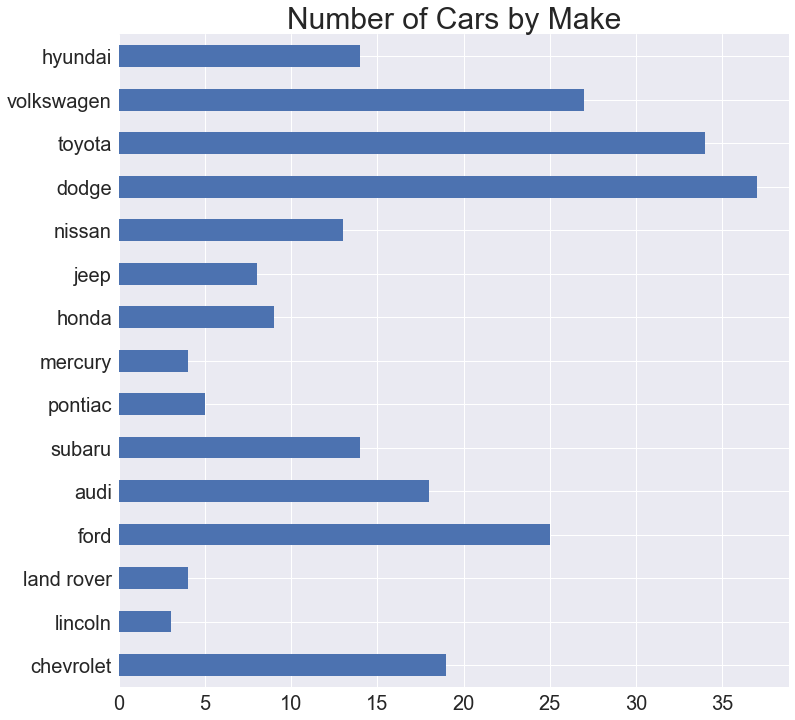

In [6]:
(mpg['manufacturer']
 .value_counts(sort=False)
 .plot.barh()
 .set_title('Number of Cars by Make')
);

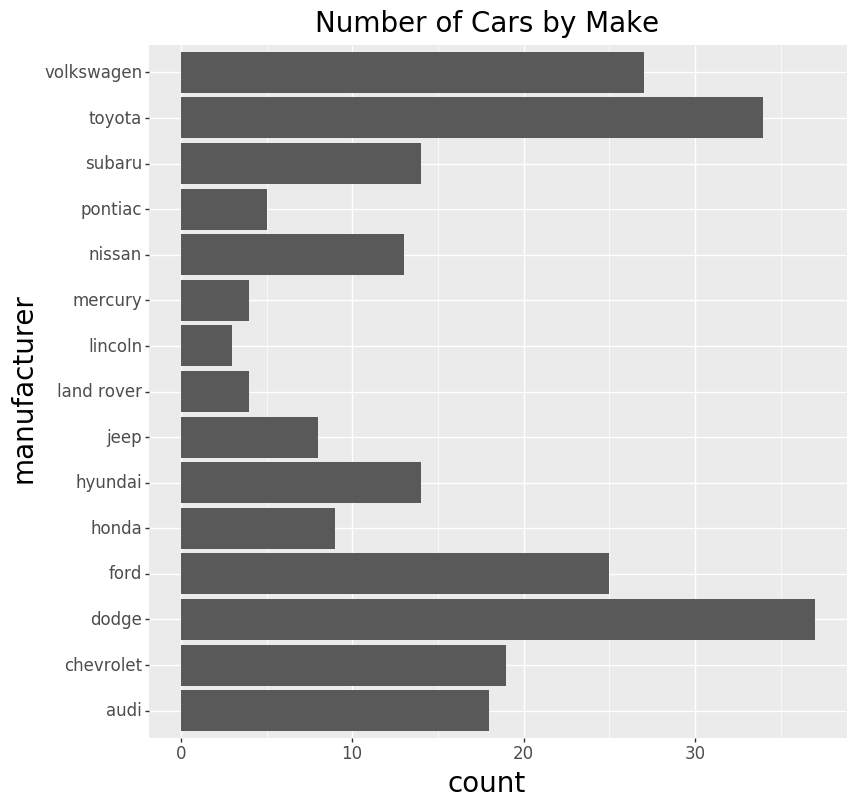

<ggplot: (296130764)>

In [7]:
"""plotnine gives an error on `ggplot(data=mpg)`.
"""
(ggplot(mpg) + 
    aes(x="manufacturer") +
    geom_bar(size=20) + 
    coord_flip() +
    ggtitle("Number of Cars by Make")
)

#### Histogram of Continuous Values

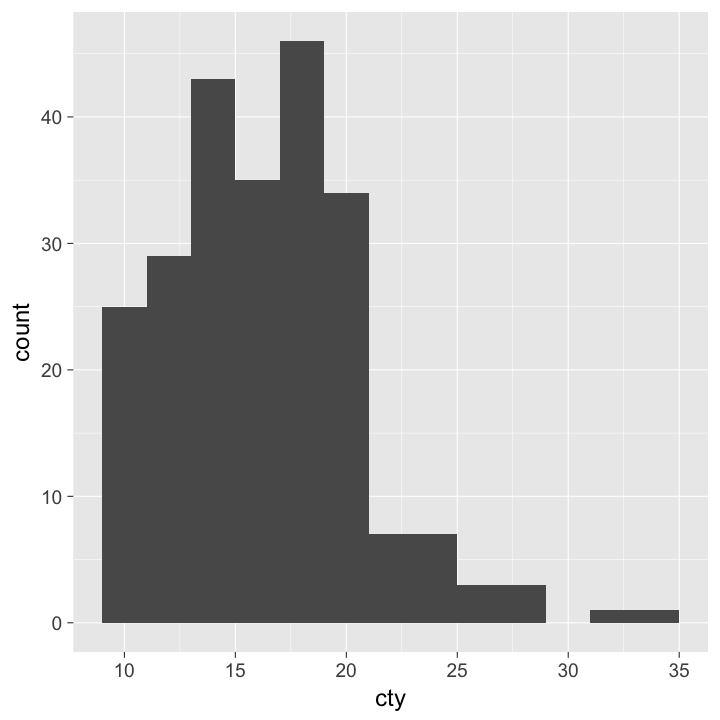

In [8]:
%%R -w 10 -h 10 -u in
ggplot(data=mpg) + 
    aes(x=cty) + 
    geom_histogram(binwidth=2)

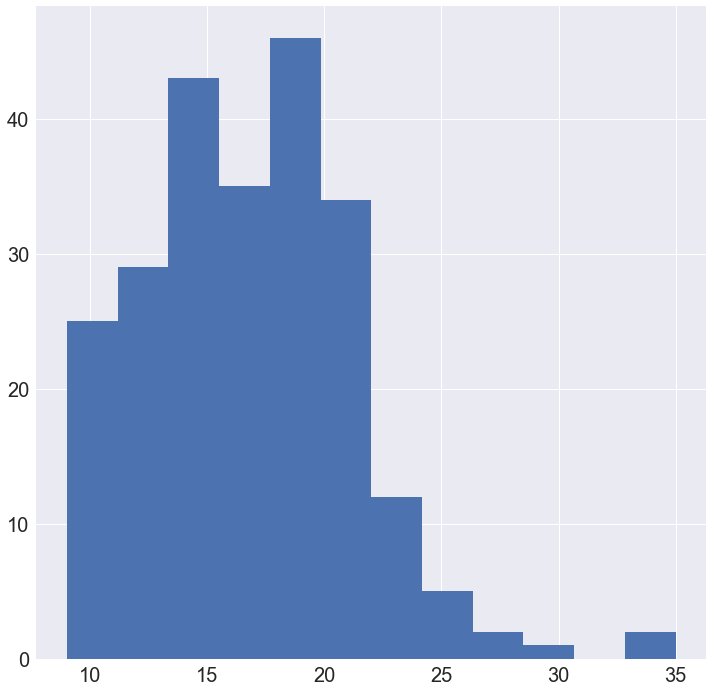

In [9]:
plt.hist('cty', bins=12, data=mpg);

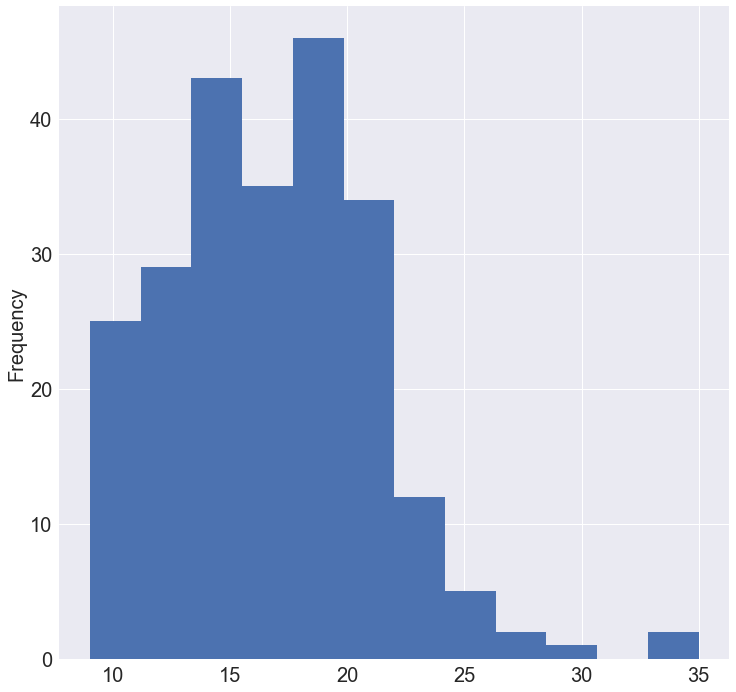

In [10]:
(mpg['cty']
 .plot
 .hist(bins=12));

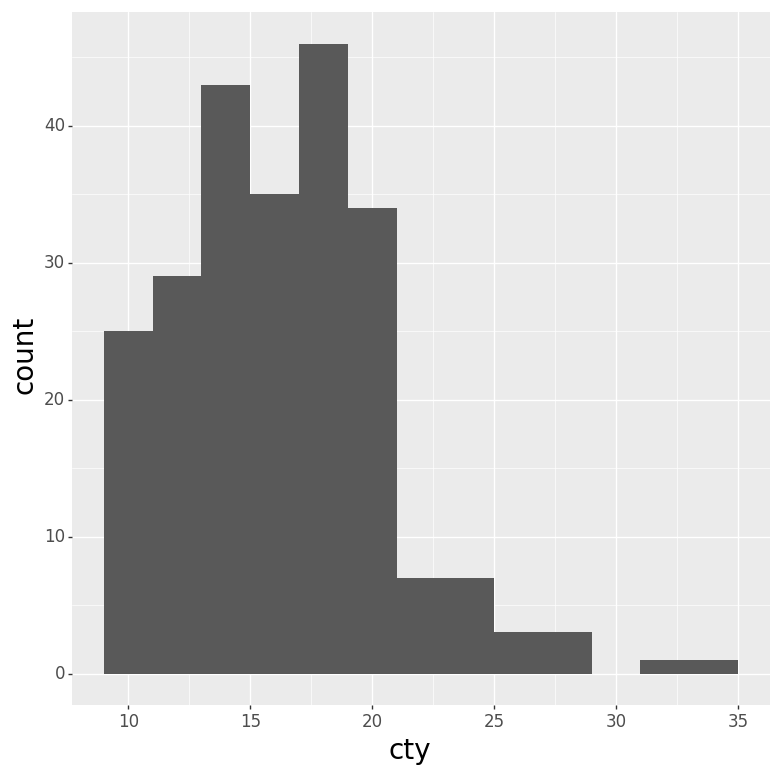

<ggplot: (294907610)>

In [11]:
(ggplot(mpg) + 
    aes(x="cty") +
    geom_histogram(binwidth=2))

#### Scatter Plot

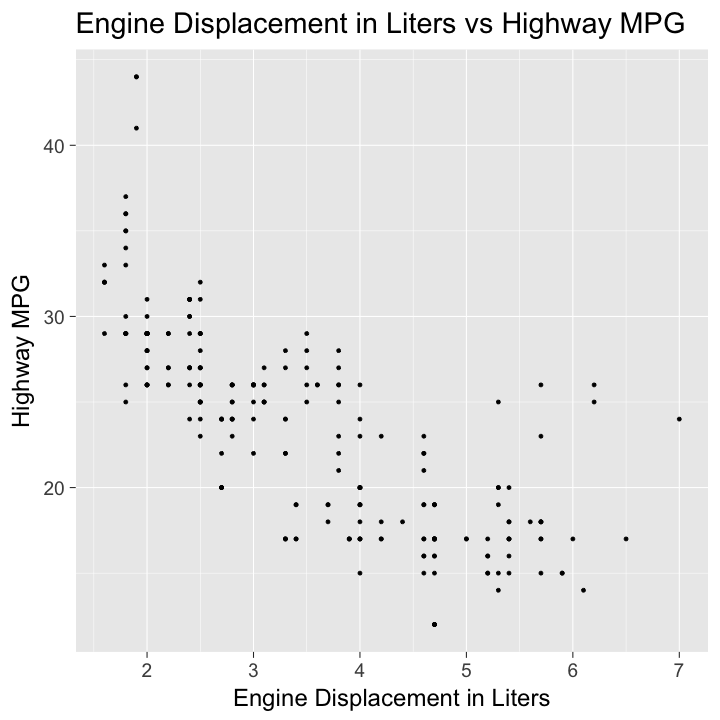

In [12]:
%%R -w 10 -h 10 -u in 
ggplot(data = mpg) +
    aes(x = displ, y = hwy) +
    geom_point() + 
    ggtitle("Engine Displacement in Liters vs Highway MPG") +
    xlab("Engine Displacement in Liters") +
    ylab("Highway MPG")

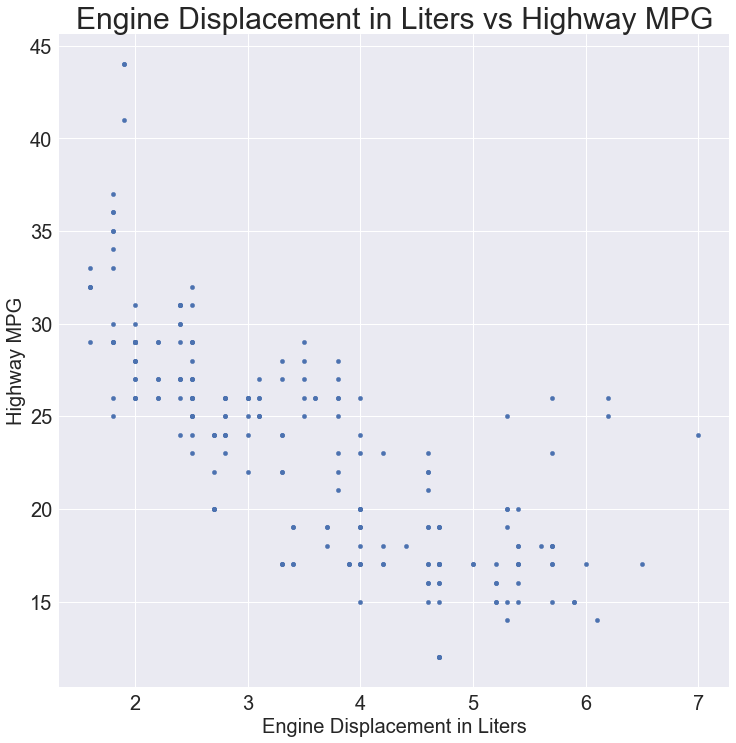

In [60]:
(mpg
 .plot
 .scatter(x='displ', y='hwy')
 .set(title='Engine Displacement in Liters vs Highway MPG',
      xlabel='Engine Displacement in Liters',
      ylabel='Highway MPG'))

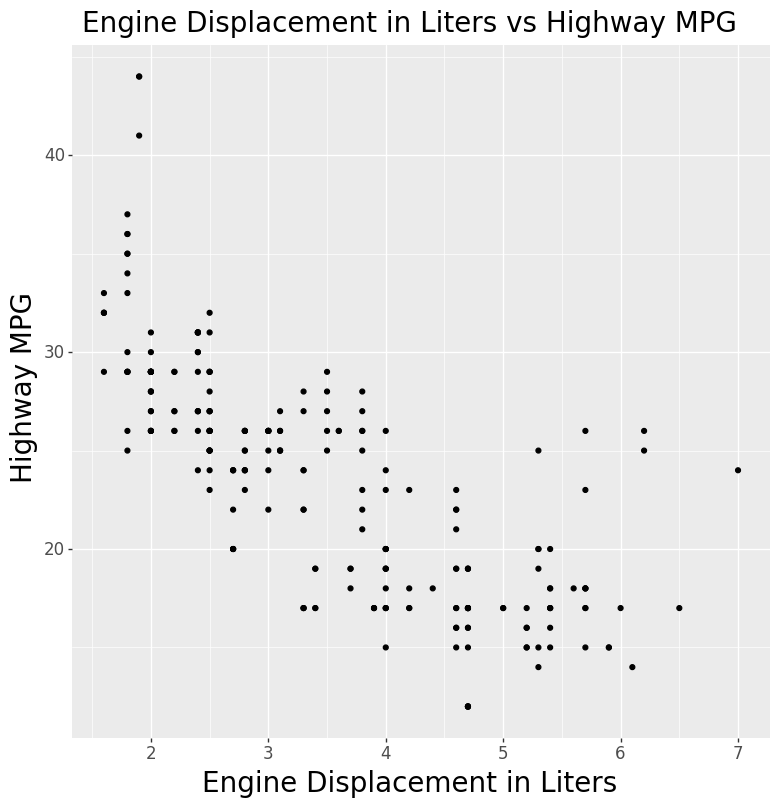

<ggplot: (296076173)>

In [14]:
(ggplot(mpg) +
    aes(x = "displ", y = "hwy") +
    geom_point() + 
    ggtitle("Engine Displacement in Liters vs Highway MPG") +
    xlab("Engine Displacement in Liters") +
    ylab("Highway MPG"))

### Advanced Scatter Plotting

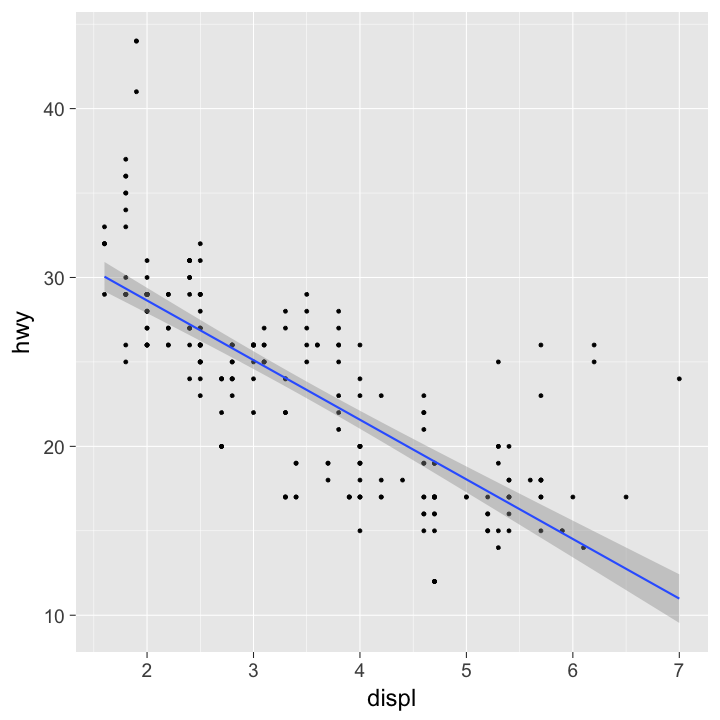

In [15]:
%%R -w 10 -h 10 -u in 
ggplot(data = mpg) +
    aes(x = displ, y = hwy) +
    geom_point() +
    geom_smooth(method=lm)

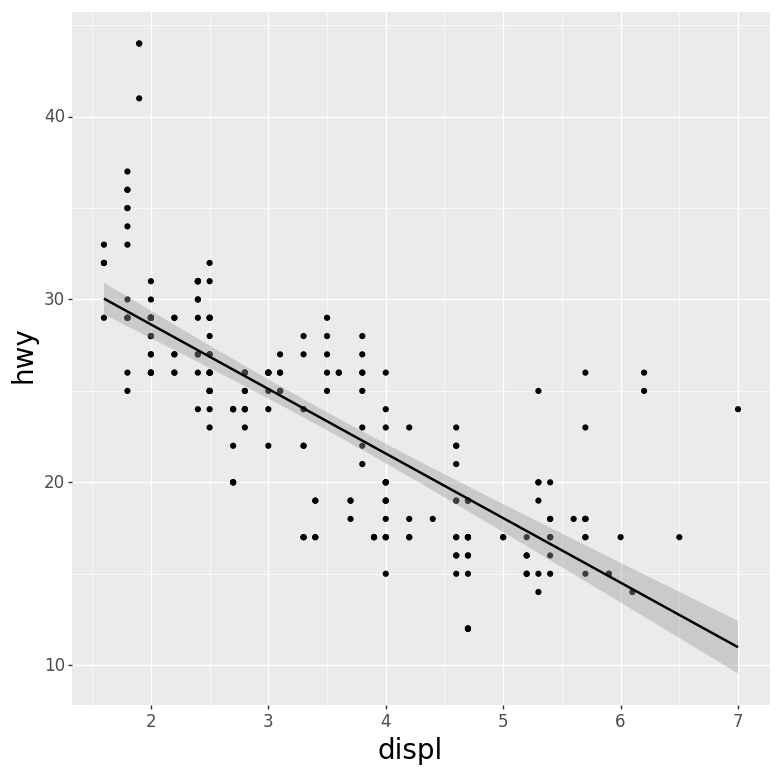

<ggplot: (296086301)>

In [16]:
(ggplot(mpg) +
    aes("displ", "hwy") +
    geom_point() +
    geom_smooth(method="lm"))

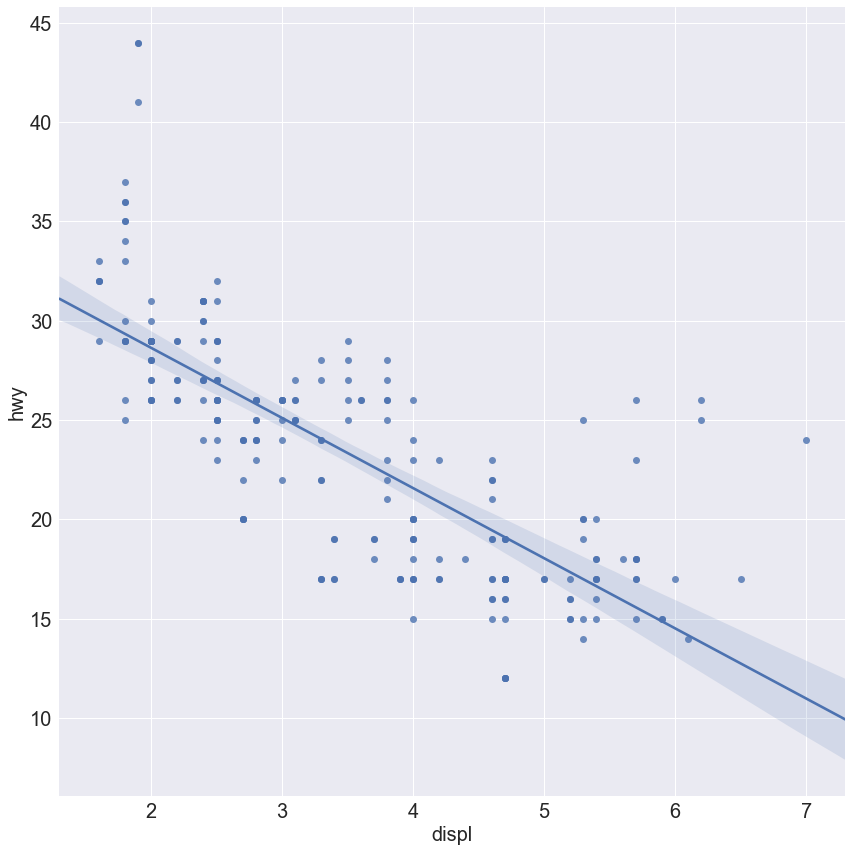

In [17]:
sns.lmplot(x="displ", y="hwy", 
           data=mpg, size=12)

#### Scatter Plot with Colors

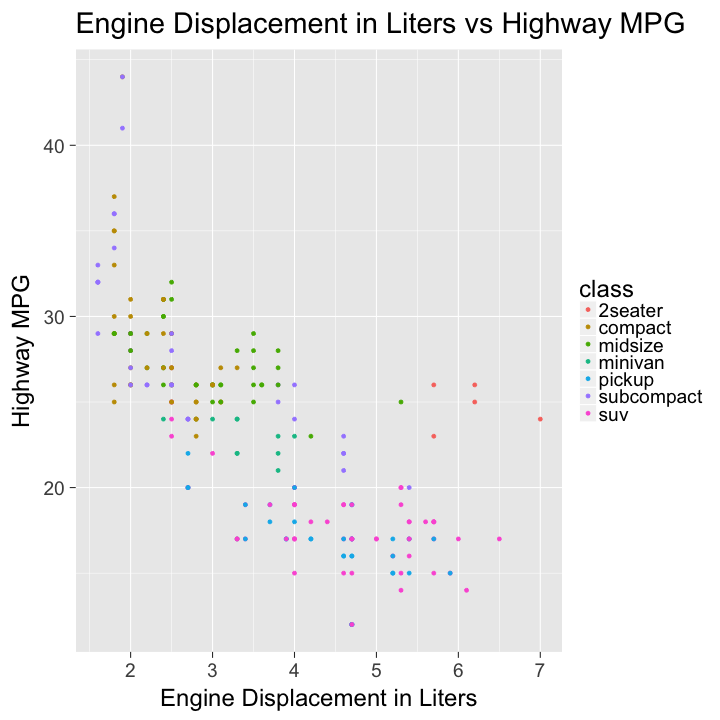

In [18]:
%%R -w 10 -h 10 -u in
ggplot(data = mpg) + 
    aes(x = displ, y = hwy, color = class) +
    geom_point() + 
    ggtitle("Engine Displacement in Liters vs Highway MPG") +
    xlab("Engine Displacement in Liters") +
    ylab("Highway MPG")

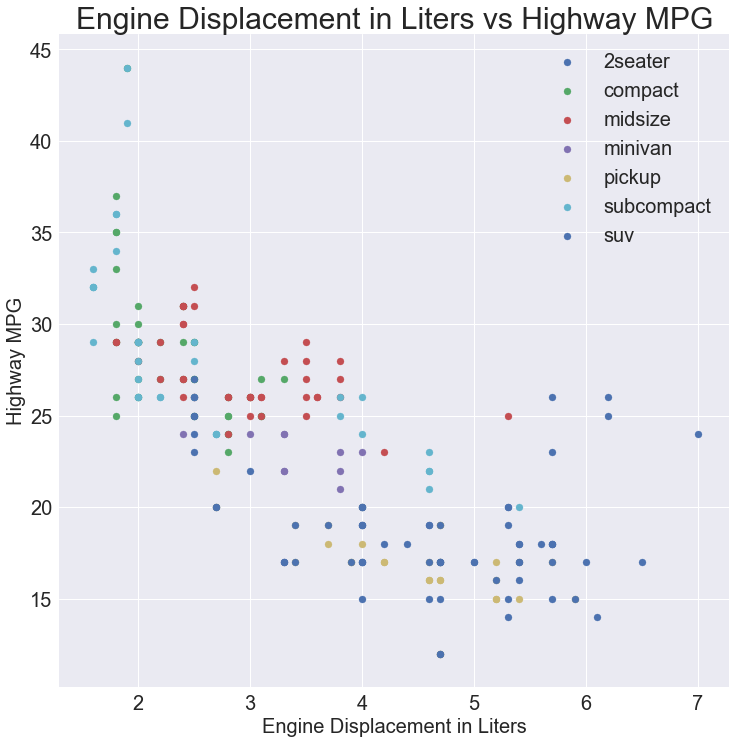

In [19]:
fig, ax = plt.subplots()
for c, df in mpg.groupby('class'):
    ax.scatter(df['displ'], df['hwy'], label=c)
ax.legend()
ax.set_title('Engine Displacement in Liters vs Highway MPG')
ax.set_xlabel('Engine Displacement in Liters')
ax.set_ylabel('Highway MPG');

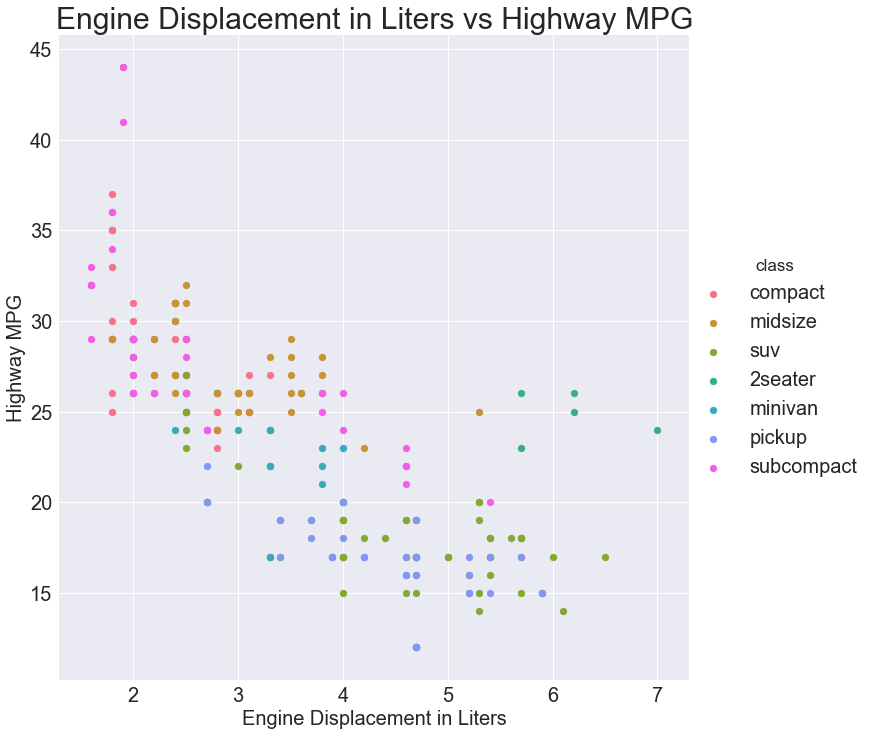

In [20]:
"""seaborn.FacetGrid overrides the `rcParams['figure.figsize'] global parameter. 
You have to set the size in the size with `size=` in `FacetGrid`"""
(sns
 .FacetGrid(mpg, hue="class", size=10)
 .map(plt.scatter, "displ", "hwy")
 .add_legend()
 .set(
    title="Engine Displacement in Liters vs Highway MPG",
    xlabel="Engine Displacement in Liters",
    ylabel="Highway MPG"
));

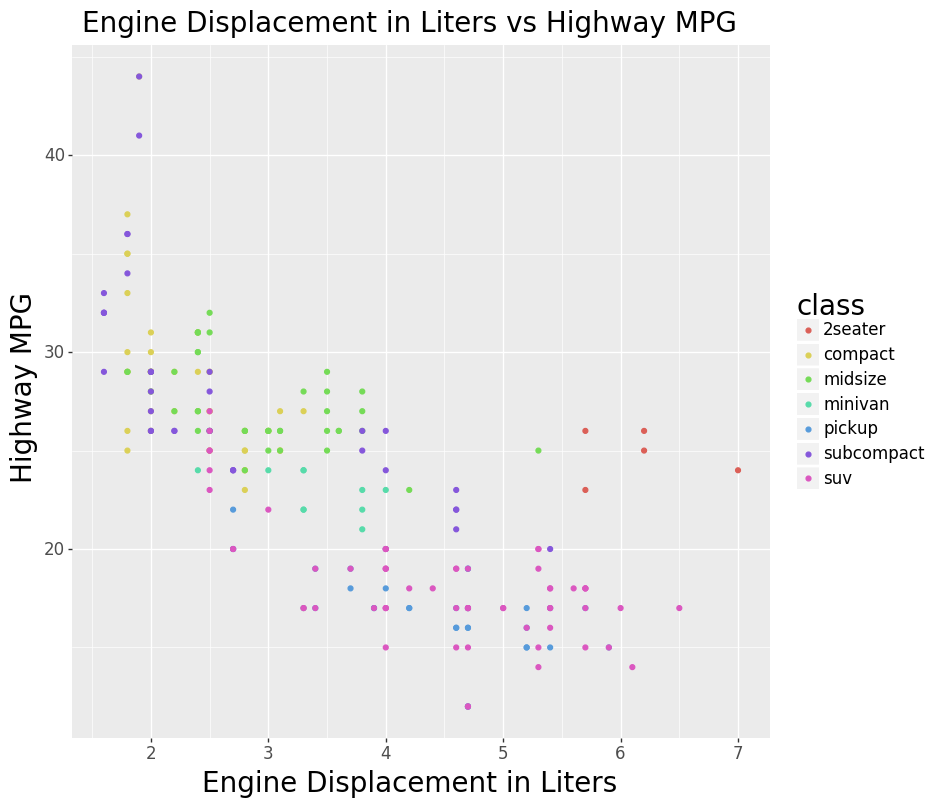

<ggplot: (-9223372036559383850)>

In [21]:
(ggplot(mpg) + 
    aes(x = "displ", y = "hwy", color = "class") +
    geom_point() + 
    ggtitle("Engine Displacement in Liters vs Highway MPG") +
    xlab("Engine Displacement in Liters") +
    ylab("Highway MPG"))

#### Scatter Plot with Sizes and Transparency

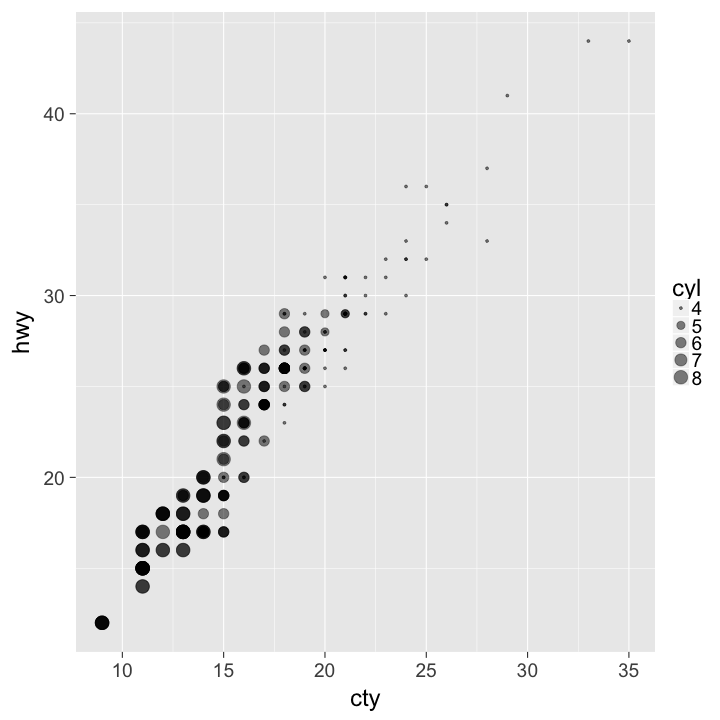

In [22]:
%%R -w 10 -h 10 -u in
ggplot(data = mpg) +
    aes(x = cty, y = hwy, size = cyl) +
    geom_point(alpha=.5)

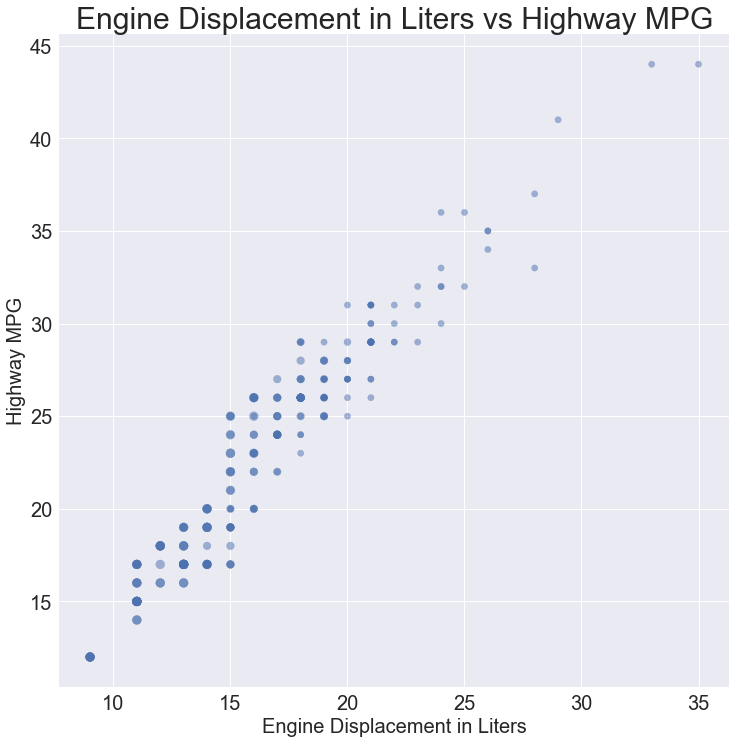

In [23]:
ax = (mpg
    .plot
    .scatter(x='cty', 
             y='hwy', 
             s=10*mpg['cyl'],
             alpha=.5))
ax.set_title('Engine Displacement in Liters vs Highway MPG')
ax.set_xlabel('Engine Displacement in Liters')
ax.set_ylabel('Highway MPG');

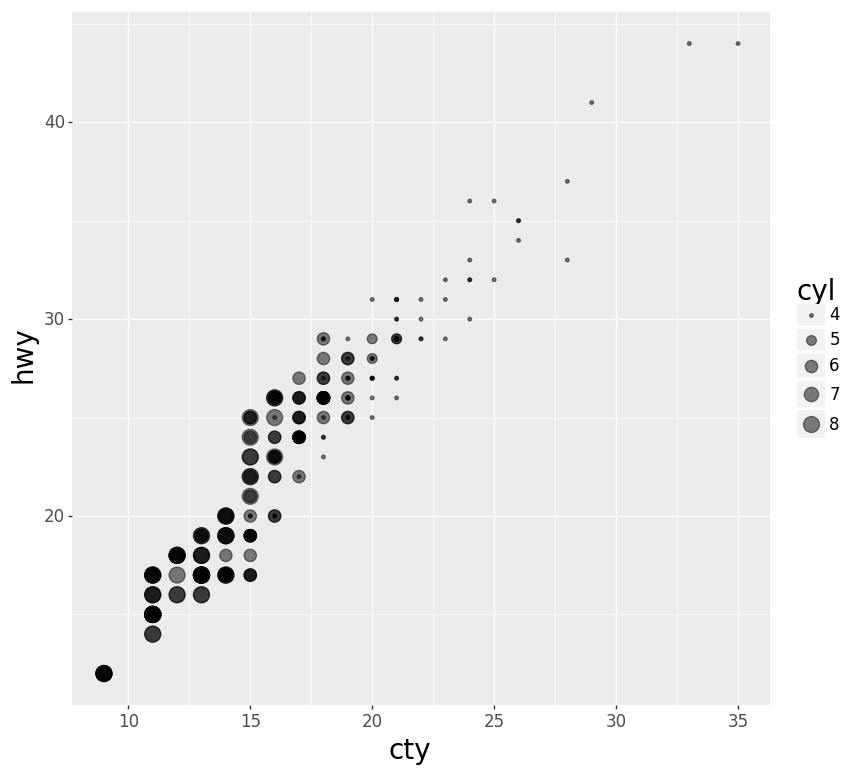

<ggplot: (-9223372036550661772)>

In [24]:
(ggplot(mpg) +
    aes(x="cty", y="hwy", size="cyl") +
    geom_point(alpha=.5))

#### Scatter Plot with Single Facet

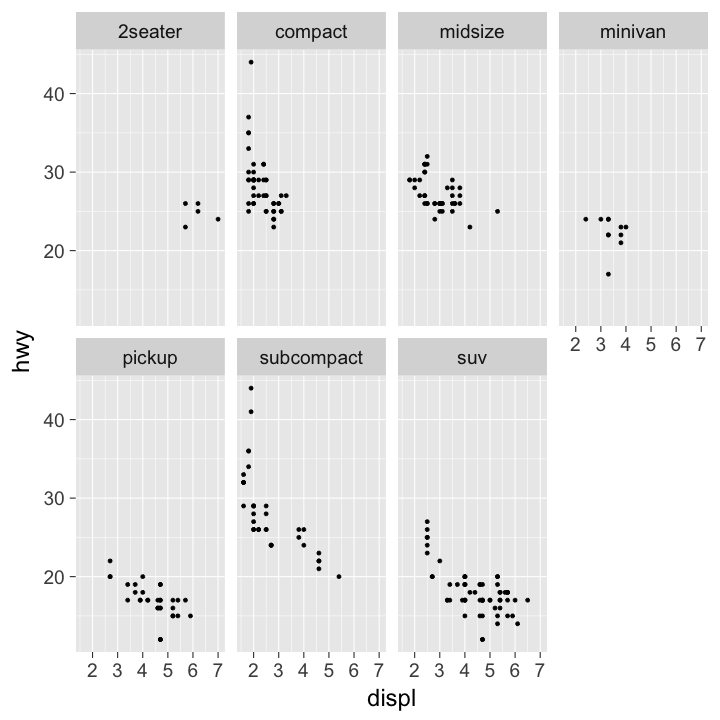

In [25]:
%%R -w 10 -h 10 -u in
ggplot(data = mpg) + 
  aes(x=displ, y=hwy) +
  geom_point() + 
  facet_wrap(~ class, nrow = 2)

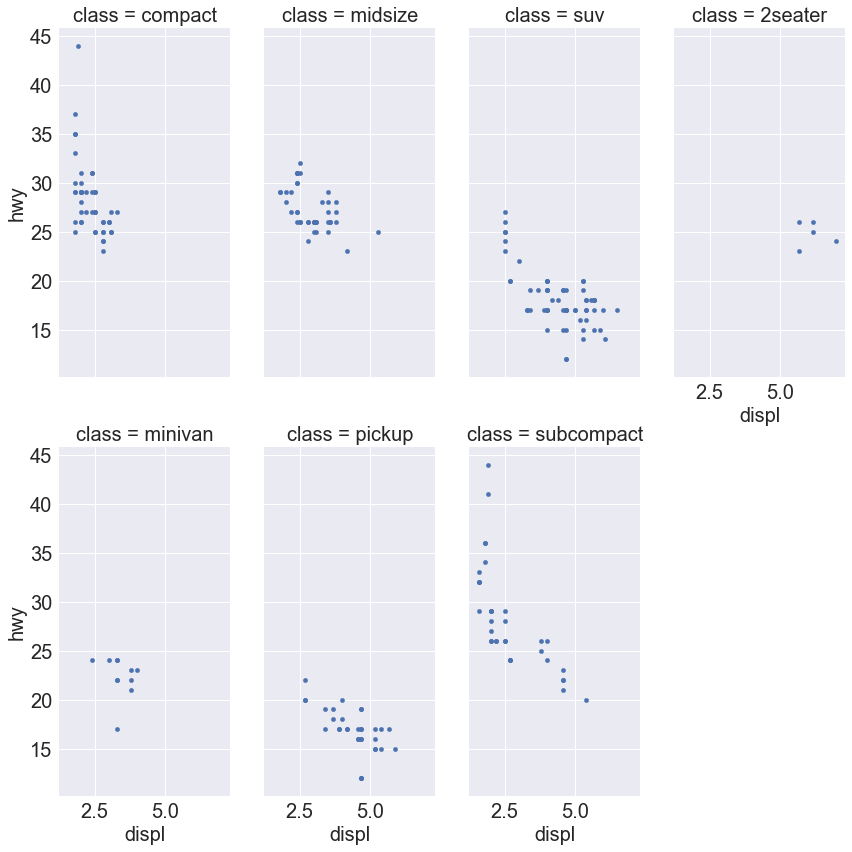

In [26]:
(mpg
 .pipe(sns.FacetGrid, 
       col="class", 
       col_wrap=4, 
       aspect=.5, 
       size=6)
 .map(plt.scatter, "displ", "hwy", s=20)
 .fig.subplots_adjust(wspace=.2, hspace=.2)
);

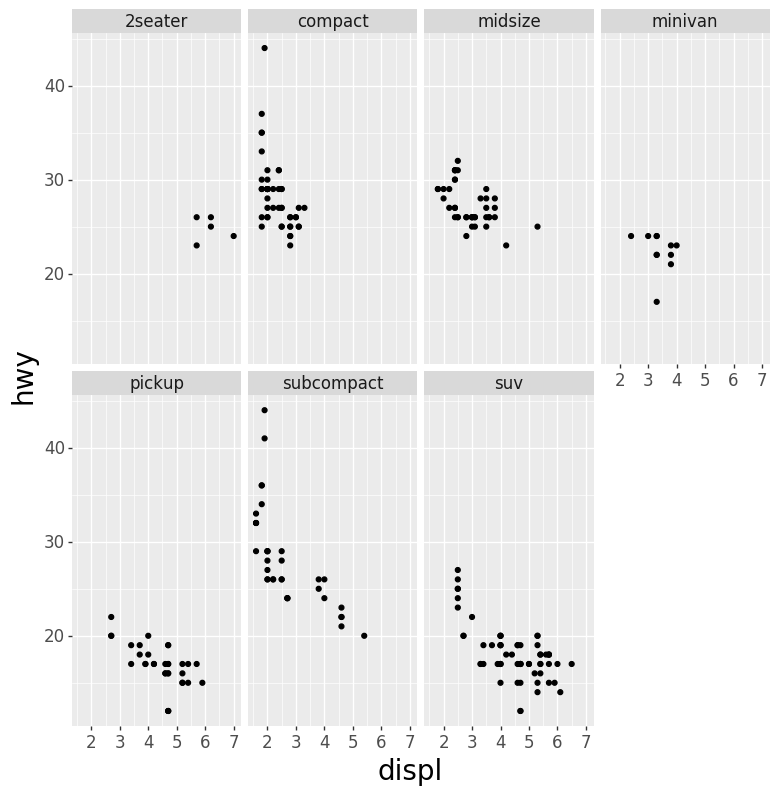

<ggplot: (304111985)>

In [27]:
(ggplot(mpg.assign(c=mpg["class"])) + 
  aes(x="displ", y="hwy") +
  geom_point() +
  facet_wrap(" ~ c", nrow = 2))

#### Scatter Plot with Facets

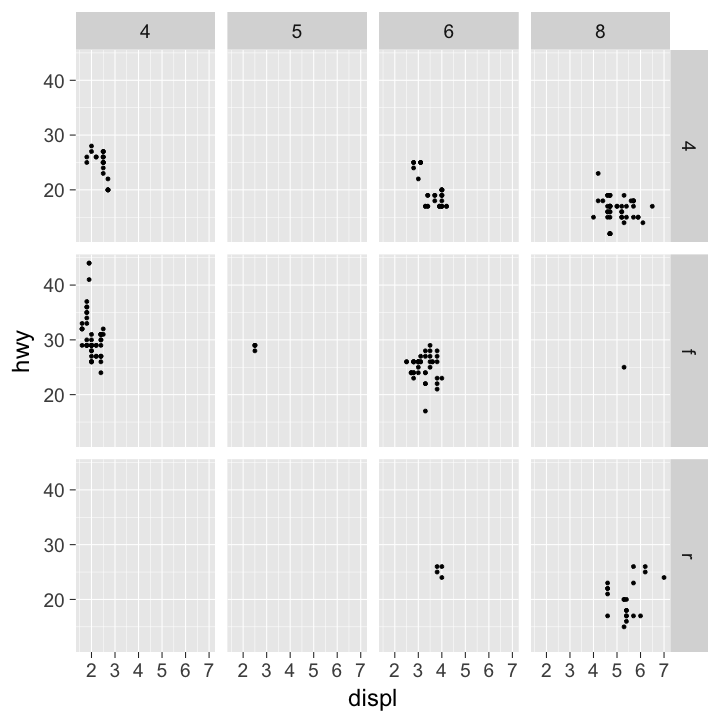

In [28]:
%%R -w 10 -h 10 -u in
ggplot(data = mpg) + 
  aes(x = displ, y = hwy) +
  geom_point() + 
  facet_grid(drv ~ cyl)

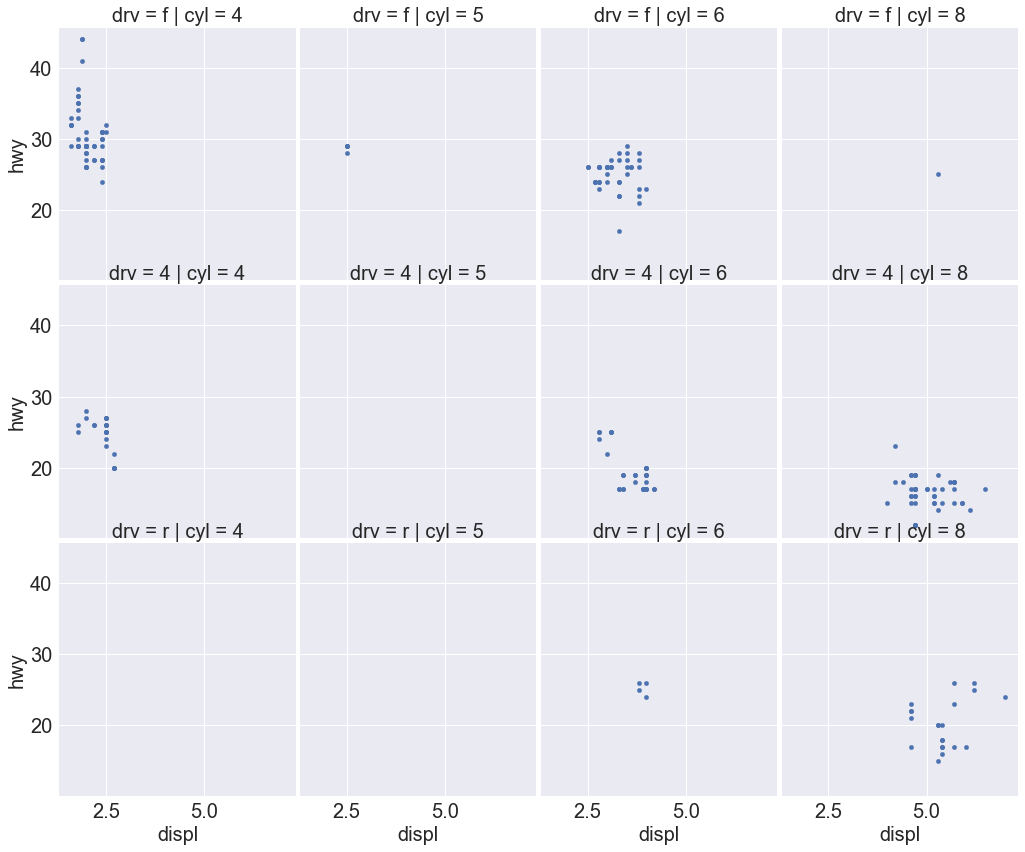

In [29]:
(mpg
 .pipe(sns.FacetGrid, 
       col="cyl", 
       row="drv", 
       aspect=.9, 
       size=4)
 .map(plt.scatter, "displ", "hwy", s=20)
 .fig.subplots_adjust(wspace=.02, hspace=.02)
);

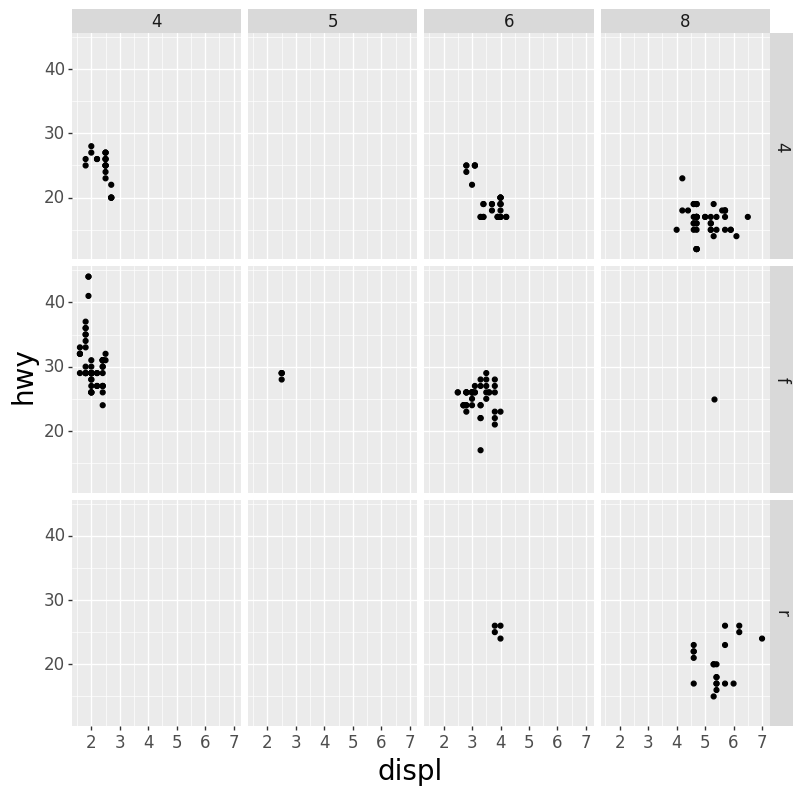

<ggplot: (-9223372036557386748)>

In [30]:
(ggplot(mpg) + 
  aes(x="displ", y="hwy") +
  geom_point() + 
  facet_grid("drv ~ cyl"))

Stacked Scatter and Smoothed Line Plot

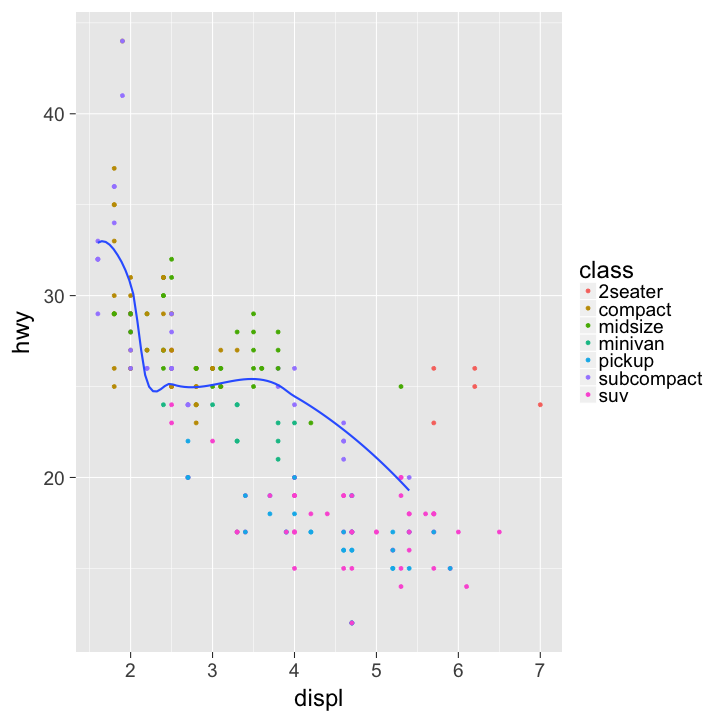

In [31]:
%%R -w 10 -h 10 -u in
subcompact = mpg[mpg$`class` == "subcompact", ]
ggplot(data = mpg, 
       mapping = aes(x = displ, y = hwy)) + 
  geom_point(mapping = aes(color = class)) + 
  geom_smooth(data = subcompact, 
              se = FALSE,
              method = 'loess')

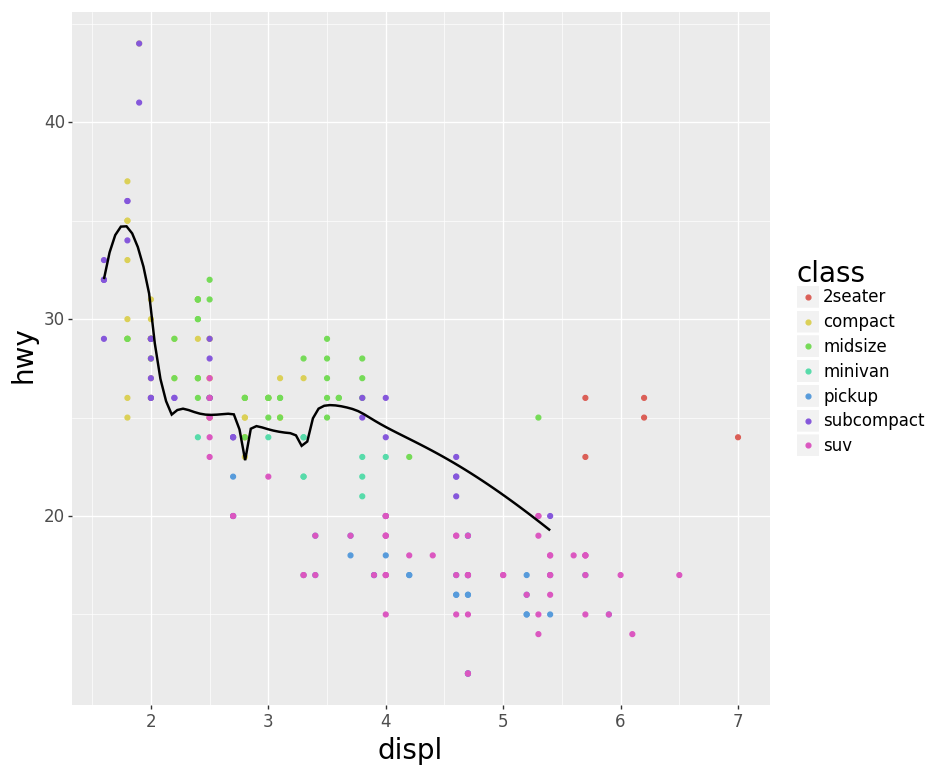

<ggplot: (293252840)>

In [32]:
"""Notice the smoothed line isn't as smooth as it is in ggplot2."""
(ggplot(data=mpg, 
        mapping=aes(x="displ", y="hwy")) + 
  geom_point(mapping=aes(color = "class")) + 
  geom_smooth(data=mpg[mpg['class'] == "subcompact"], 
              se=False,
              method = 'loess'
             ))

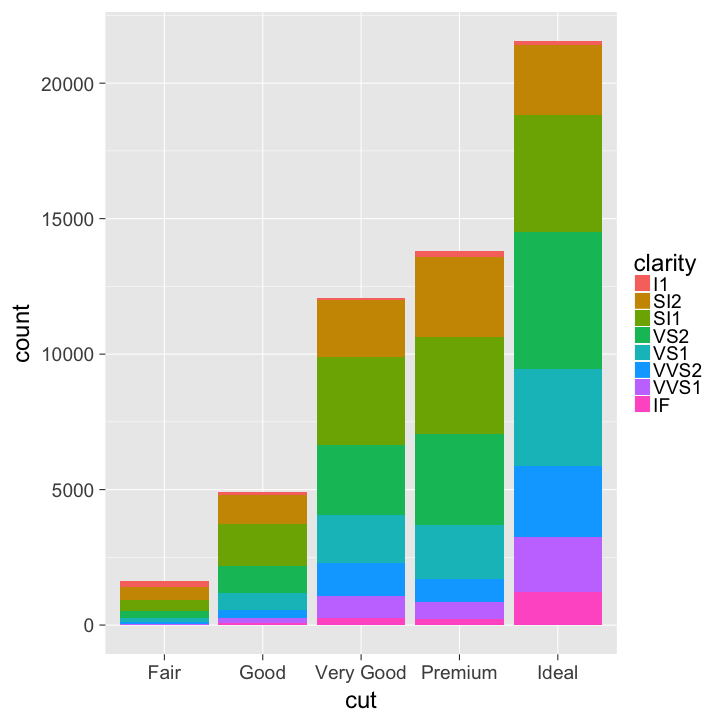

In [33]:
%%R -w 10 -h 10 -u in
ggplot(data = diamonds) + 
  aes(x = cut, fill = clarity) +
  geom_bar()

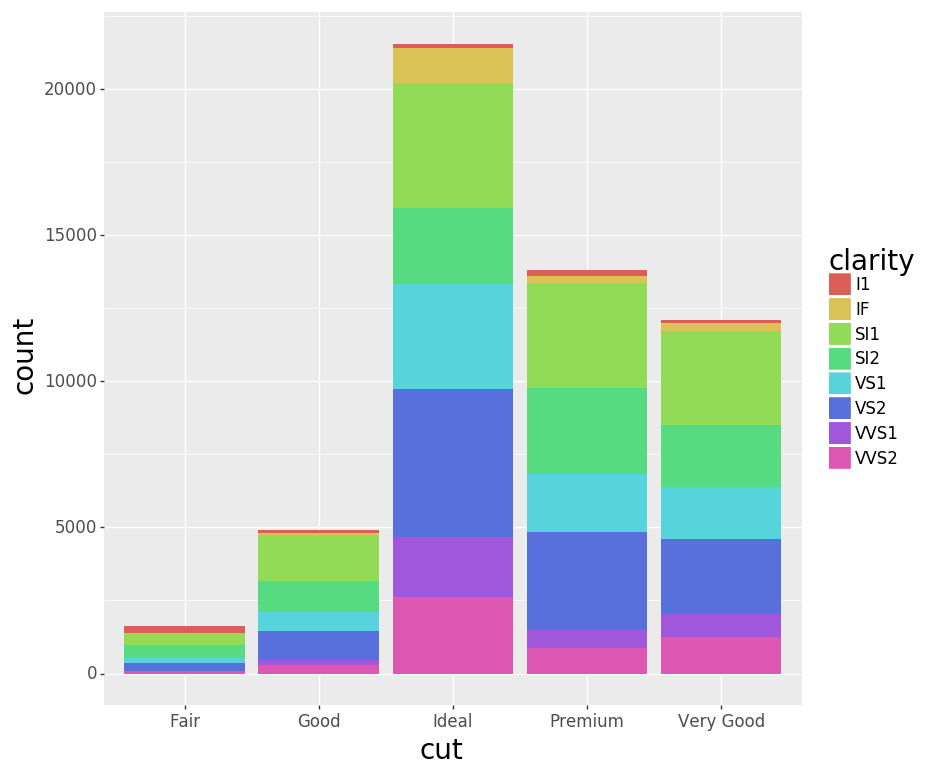

<ggplot: (-9223372036560148308)>

In [34]:
(ggplot(diamonds) + 
  aes(x="cut", fill="clarity") +
  geom_bar())

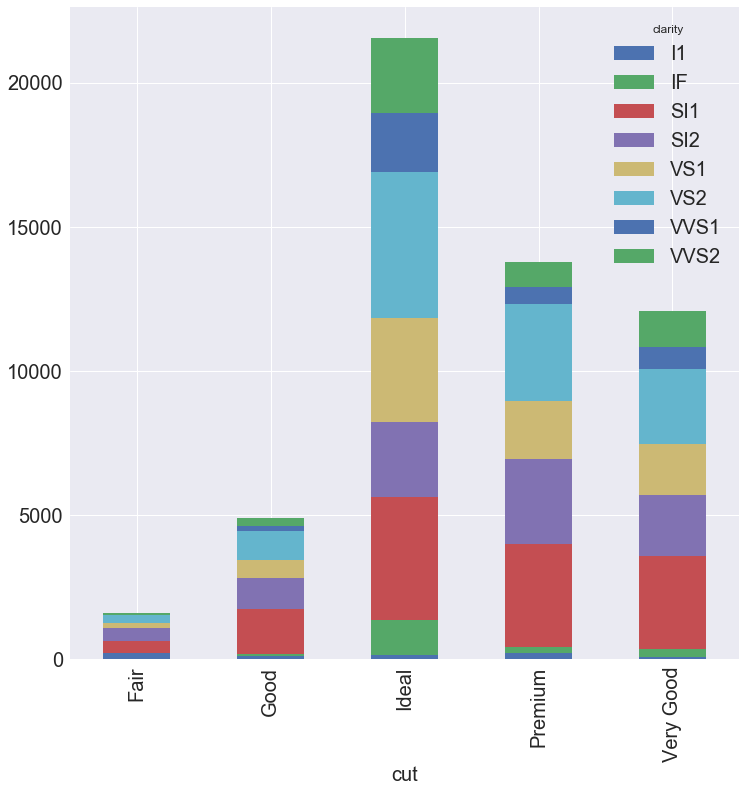

In [35]:
(diamonds
 .groupby(['cut', 'clarity'])
 .size()
 .unstack()
 .plot.bar(stacked=True)
);

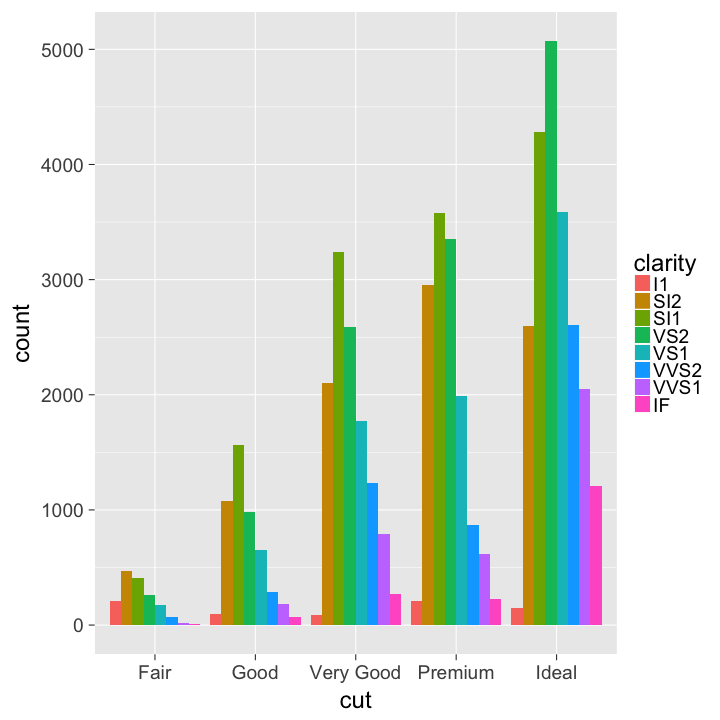

In [36]:
%%R -w 10 -h 10 -u in
ggplot(data = diamonds) + 
  aes(x = cut, fill = clarity) +
  geom_bar(position = "dodge")

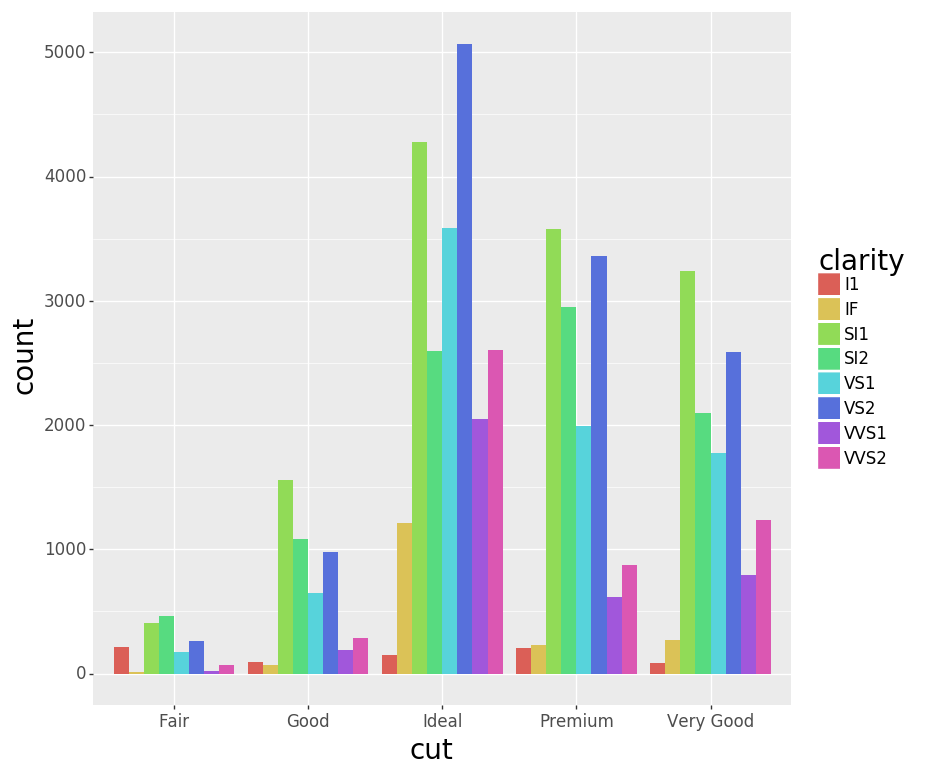

<ggplot: (297028349)>

In [37]:
(ggplot(diamonds) + 
  aes(x='cut', fill='clarity') +
  geom_bar(position = "dodge"))


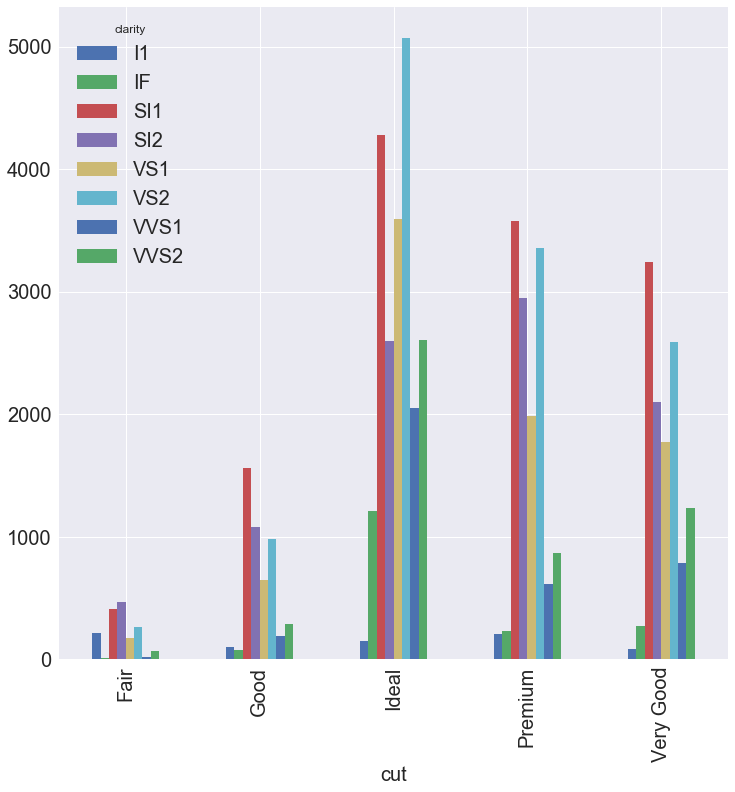

In [38]:
(diamonds
 .groupby(['cut', 'clarity'])
 .size()
 .unstack()
 .plot.bar()
);

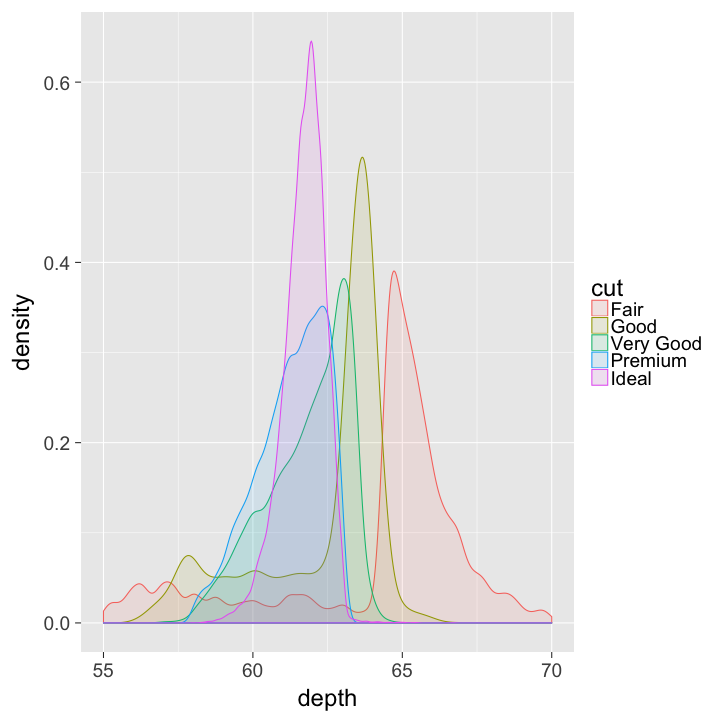

In [39]:
%%R -w 10 -h 10 -u in
ggplot(diamonds) +
  aes(depth, fill = cut, colour = cut) +
  geom_density(alpha = 0.1) +
  xlim(55, 70)

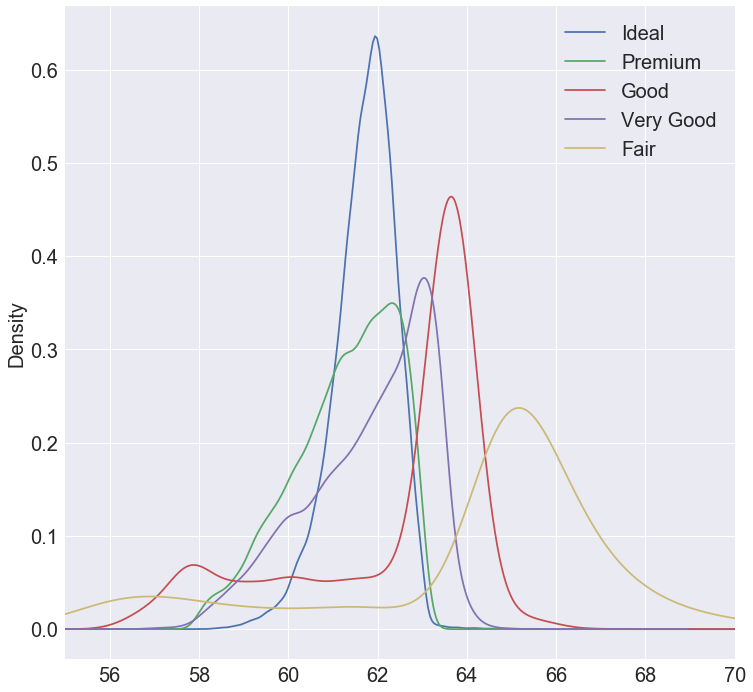

In [40]:
"""I don't know whether Pandas can fill a KDE curve.

This requires using some Matplotlib to get them to stack and to have a legend.
"""
fig, ax = plt.subplots()
ax.set_xlim(55, 70)
for cut in diamonds['cut'].unique():
    s = diamonds[diamonds["cut"] == cut]['depth']
    s.plot.kde(ax=ax, label=cut)
ax.legend()

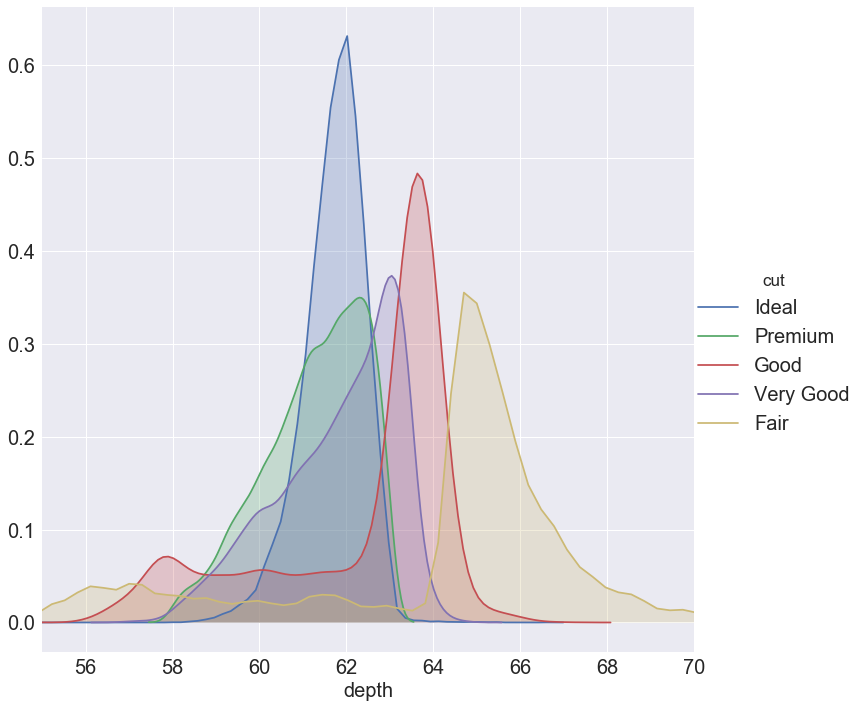

In [41]:
(sns
  .FacetGrid(diamonds, 
             hue="cut", 
             size=10, 
             xlim=(55, 70))
  .map(sns.kdeplot, 'depth', shade=True)
 .add_legend()
);

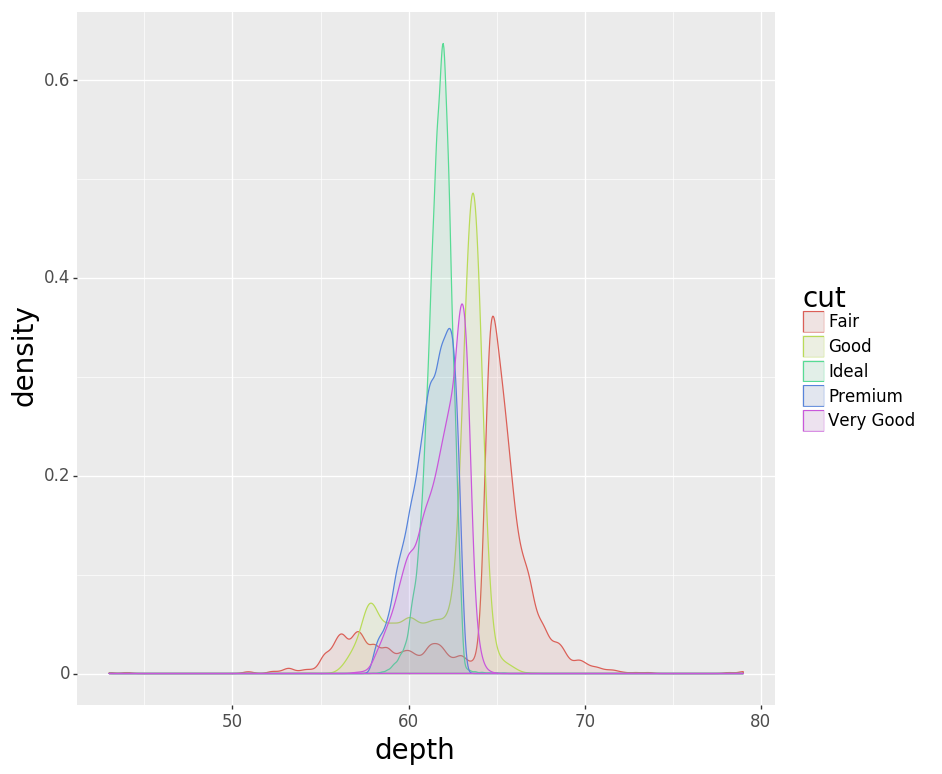

<ggplot: (297230575)>

In [42]:
"""`+ xlim(55, 70)` results in an error."""
(ggplot(diamonds) +
  aes('depth', fill='cut', color='cut') +
  geom_density(alpha=0.1))

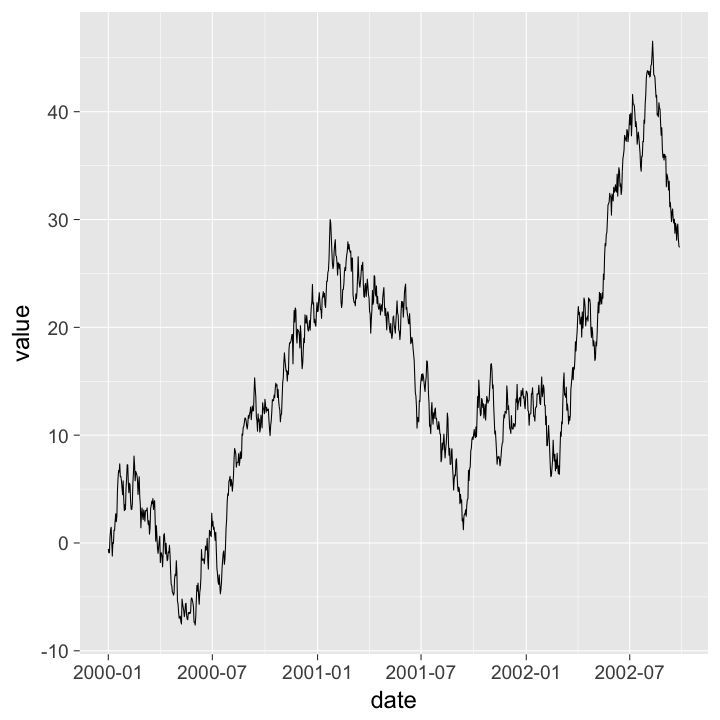

In [44]:
%%R -i ts -w 10 -h 10 -u in 
ggplot(ts) + aes(date, value) + geom_line()

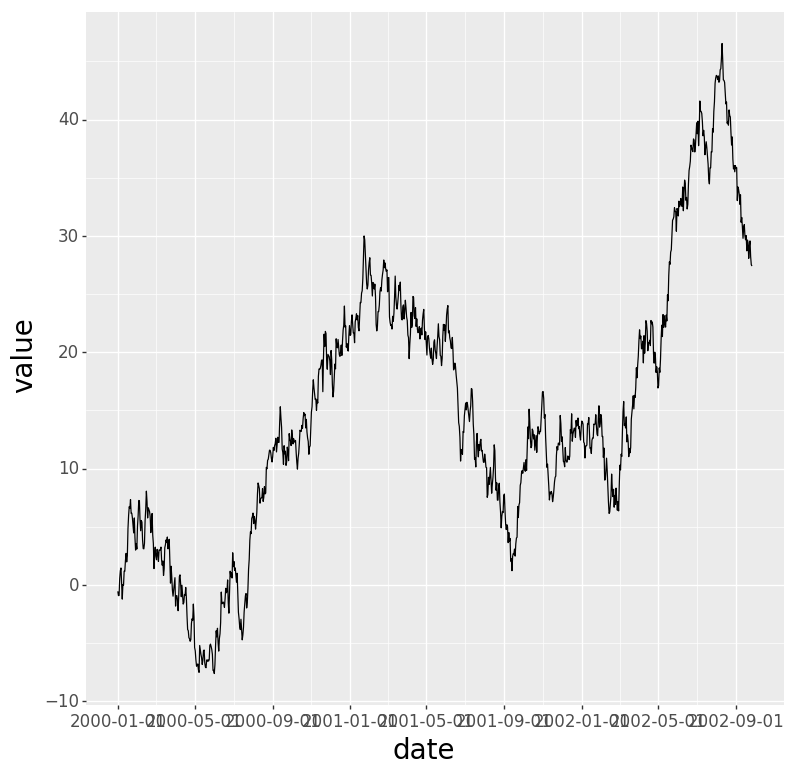

<ggplot: (-9223372036550289078)>

In [45]:
(ggplot(ts) 
 + aes("date", "value") 
 + geom_line())

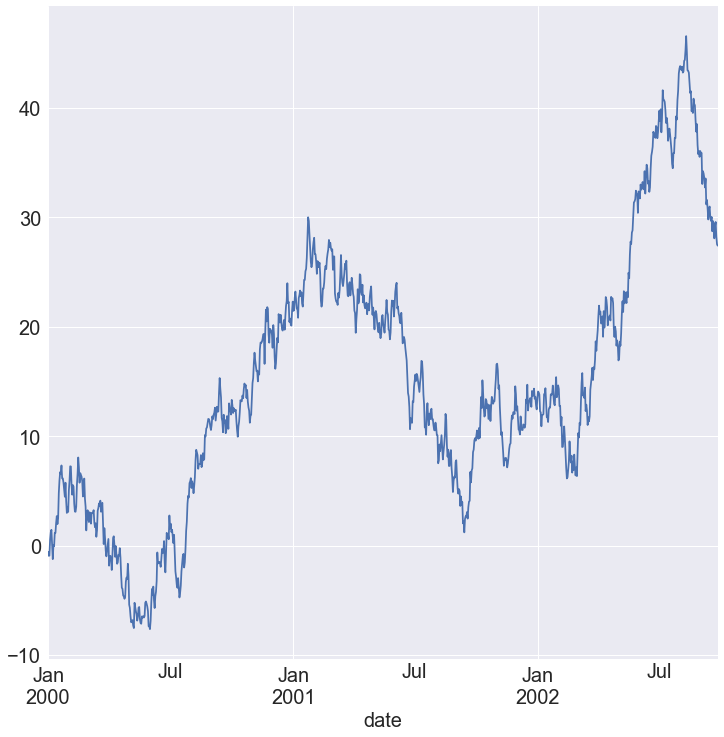

In [46]:
ts.set_index('date')['value'].plot()